<a href="https://colab.research.google.com/github/liuyixin-louis/dl_learning/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lstm
## 疫情期间网民情绪识别 https://www.datafountain.cn/competitions/423/datasets

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
# 数据导入及初步分析
import pandas as pd

import pandas as pd #导入Pandas
import numpy as np #导入Numpy
import jieba #导入结巴分词

from tensorflow.keras import backend
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop, Adagrad
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU

from __future__ import absolute_import #导入3.x的特征函数
from __future__ import print_function

In [0]:
#　导入数据
label_data = pd.read_csv('/content/drive/My Drive/nCoV_100k_train.labled.csv',encoding="utf-8")
exam_data = pd.read_csv('/content/drive/My Drive/exam.csv',encoding="utf-8")

In [330]:

label_data

,微博id,微博发布时间,发布人账号,微博中文内容,微博图片,微博视频,情感倾向
0,4456072029125500,01月01日 23:50,存曦1988,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,['https://ww2.sinaimg.cn/orj360/005VnA1zly1gah...,[],0
1,4456074167480980,01月01日 23:58,LunaKrys,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,[],[],-1
2,4456054253264520,01月01日 22:39,小王爷学辩论o_O,邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新...,['https://ww2.sinaimg.cn/thumb150/006ymYXKgy1g...,[],1
3,4456061509126470,01月01日 23:08,芩鎟,新年的第一天感冒又发烧的也太衰了但是我要想着明天一定会好的?,['https://ww2.sinaimg.cn/orj360/005FL9LZgy1gah...,[],1
4,4455979322528190,01月01日 17:42,changlwj,问：我们意念里有坏的想法了，天神就会给记下来，那如果有好的想法也会被记下来吗？答：那当然了。...,[],[],1
...,...,...,...,...,...,...,...
99995,4473033438259880,02月17日 19:08,中国教育新闻网,#抗击新型肺炎第一线#【@中国计量大学研制新冠病毒蛋白标准样品】记者从中国计量大学获悉，新型...,['https://ww1.sinaimg.cn/orj360/682cebefly1gbz...,[],0
99996,4472969222714290,02月17日 14:53,fuzhuoting,1、类RaTG13病毒（一种从云南蝙蝠身上分离出来的冠状病毒）可能是2019-nCoV的源头...,[],[],0
99997,4473035904435920,02月17日 19:18,蝌蚪五线谱,#微博辟谣#没有证据表明，吃大蒜、漱口水、涂抹芝麻油、生理盐水洗鼻子等手段可以防止感染新型冠...,['https://ww4.sinaimg.cn/orj360/6d2cc4e6ly1gbz...,[],0
99998,4472950743017610,02月17日 13:40,医库,【新冠疫情最受关注的十一篇英文核心期刊论文全解析】本文整理了关于新型冠状病毒最受关注的十一篇...,[],[],1


In [331]:
exam_data

,id,word,Unnamed: 2
0,4.456070e+15,#你好2020#新年第一天元气满满的早起出门买早饭结果高估了自己抗冻能力回家成功冻发烧（大概...,NaN
1,4.456420e+15,大宝又感冒鼻塞咳嗽了，还有发烧。队友加班几天不回。感觉自己的情绪在家已然是随时引爆的状态。情...,NaN
2,4.456800e+15,还要去输两天液，这天也太容易感冒发烧了，一定要多喝热水啊?,NaN
3,4.456790e+15,我太难了别人怎么发烧都没事就我一检查甲型流感?,NaN
4,4.457090e+15,果然是要病一场的喽回来第三天开始感冒今儿还发烧了喉咙眼睛都难受的一匹怎么样能不经意让我的毕设...,NaN
...,...,...,...
9995,4.464180e+15,「2020的黑天鹅事件」>2019-nCov?,NaN
9996,4.464270e+15,心灵鸡汤#武汉加油#我们所有人，和我们这个国家一起，正在经历着一场这个星球上史无前例的考验...,NaN
9997,4.464290e+15,武大人民医院：发热咳嗽并非新冠肺炎的唯一首发症状(来自@界面新闻)武汉大学人民医院研究组1月...,NaN
9998,4.465350e+15,闭关第二天发现一根白发2019-nCoV?,NaN


In [0]:
cw = lambda x: list(jieba.cut(x)) #定义分词函数

In [0]:
label_data = label_data[['微博中文内容','情感倾向']] 
exam_data = exam_data[['id','word']]
label_data = label_data[label_data['微博中文内容'].notnull()] #仅读取非空评论
# exam_data = exam_data[exam_data['word'].notnull()] #仅读取非空评论
exam_data['word'] = exam_data['word'].fillna('的')
label_data['微博中文内容'] = label_data['微博中文内容'].apply(cw) #评论分词 
exam_data['word'] = exam_data['word'].apply(cw) #评论分词 

In [0]:
d2v_train = pd.concat([label_data['微博中文内容'],exam_data['word']], ignore_index = True) 
w = [] #将所有词语整合在一起
for i in d2v_train:
    w.extend(i)
dict = pd.DataFrame(pd.Series(w).value_counts()) #统计词的出现次数
del w,d2v_train
dict['id']=list(range(1,len(dict)+1))
dict
pn =label_data
pn.columns=['words','mark']
get_sent = lambda x: list(dict['id'][x])
pn['sent'] = pn['words'].apply(get_sent) #速度太慢

#　扩开
maxlen = 1000
print("Pad sequences (samples x time)")
pn['sent'] = list(sequence.pad_sequences(pn['sent'], maxlen=maxlen))


In [0]:
# 数据集划分
x = np.array(list(pn['sent']))[::2] #训练集
y = np.array(list(pn['mark']))[::2]
xt = np.array(list(pn['sent']))[1::2] #测试集
yt = np.array(list(pn['mark']))[1::2]
xa = np.array(list(pn['sent'])) #全集
ya = np.array(list(pn['mark']))

In [282]:
def fix_softmax_3(y):
  ｌ= []
  for i in range(len(y)):
    if y[i]=='-1':
      l.append([1,0,0])
    elif y[i]=='0':
      l.append([0,1,0])
    else:
      l.append([0,0,1])
  return np.array(l)
y = fix_softmax_3(y)
yt = fix_softmax_3(yt)
ya = fix_softmax_3(ya)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [283]:
ya

array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]])

In [284]:
# import tensorflow as tf
print('Build model...')
model = Sequential()
model.add(Embedding(len(dict)+1, 256))
model.add(LSTM(128)) # try using a GRU instead, for fun
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax')) # Dense=>全连接层,输出维度=3
model.add(Activation('softmax'))
# model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Build model...


In [285]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 256)         40832768  
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 387       
_________________________________________________________________
activation_13 (Activation)   (None, 3)                 0         
Total params: 41,030,275
Trainable params: 41,030,275
Non-trainable params: 0
_________________________________________________________________


In [286]:
# all in train
model.fit(xa, ya, batch_size=16, nb_epoch=1,verbose=1) #训练时间为若干个小时


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/1
99646/99646 [==============================] - 445s 4ms/step - loss: 0.5224 - acc: 0.7768


In [287]:
# 损失和准确率
loss, accuracy = model.evaluate(xt, yt)

49823/49823 [==============================] - 20s 404us/step


In [288]:
print('test loss: ', loss)
print('test accuracy: ', accuracy)

test loss:  0.7619767839002788
test accuracy:  0.5011474107681737


# exam

In [289]:
exam_data

,id,word
0,4.456070e+15,"[#, 你好, 2020, #, 新年, 第一天, 元气, 满满的, 早起, 出门, 买, ..."
1,4.456420e+15,"[大宝, 又, 感冒, 鼻塞, 咳嗽, 了, ，, 还有, 发烧, 。, 队友, 加班, 几..."
2,4.456800e+15,"[还要, 去, 输, 两天, 液, ，, 这天, 也, 太, 容易, 感冒, 发烧, 了, ..."
3,4.456790e+15,"[我太难, 了, 别人, 怎么, 发烧, 都, 没事, 就, 我, 一, 检查, 甲型, 流..."
4,4.457090e+15,"[果然, 是, 要, 病, 一场, 的, 喽, 回来, 第三天, 开始, 感冒, 今儿, 还..."
...,...,...
9995,4.464180e+15,"[「, 2020, 的, 黑天鹅, 事件, 」, >, 2019, -, nCov, ?]"
9996,4.464270e+15,"[, 心灵鸡汤, #, 武汉, 加油, #, 我们, 所有人, ，, 和, 我们, 这个,..."
9997,4.464290e+15,"[武大, 人民, 医院, ：, 发热, 咳嗽, 并非, 新冠, 肺炎, 的, 唯一, 首发,..."
9998,4.465350e+15,"[闭关, 第二天, 发现, 一根, 白发, 2019, -, nCoV, ?]"


In [290]:
get_sent = lambda x: list(dict['id'][x])
exam_data['sent'] = exam_data['word'].apply(get_sent) #转索引矩阵
# 扩开：
maxlen = 50
print("Pad sequences (samples x time)")
exam_data['sent'] = list(sequence.pad_sequences(exam_data['sent'], maxlen=maxlen))

Pad sequences (samples x time)


In [0]:
xe = np.array(list(exam_data['sent'])) #全集

In [295]:
xe.shape

(10000, 50)

In [0]:
result = model.predict_classes(xe)

In [297]:
result

array([0, 1, 0, ..., 1, 1, 1])

In [300]:
np.sum(result==1)

7095

In [0]:
result[result==2]=20
result[result==1]=10
result[result==0]=-10

result[result==20]=1
result[result==10]=0
result[result==-10]=-1

In [302]:
result

array([-1,  0, -1, ...,  0,  0,  0])

In [305]:
np.sum(result==0)

7095

In [0]:
# 打包
exam_data['y'] = result

In [0]:
result = exam_data[['id','y']]

In [0]:
result.to_csv('./result1.csv')

In [309]:
result

,id,y
0,4.456070e+15,-1
1,4.456420e+15,0
2,4.456800e+15,-1
3,4.456790e+15,-1
4,4.457090e+15,-1
...,...,...
9995,4.464180e+15,0
9996,4.464270e+15,0
9997,4.464290e+15,0
9998,4.465350e+15,0


In [310]:
print('asd')

asd


In [0]:
sample = pd.read_csv('/content/drive/My Drive/sample.csv')

In [312]:
sample

,id,y
0,4456068992182160,-1
1,4456424178427250,0
2,4456797466940200,0
3,4456791021108920,0
4,4457086404997440,1
...,...,...
9995,4464179518243680,0
9996,4464274073923100,0
9997,4464289160945130,0
9998,4465347950314820,0


In [0]:
sample['y'] = result['y']

In [0]:
sample.to_csv('./result2.csv',index=False,float_format='%d')

哈哈哈。。



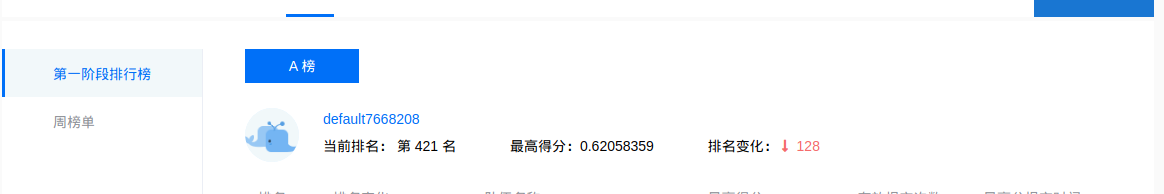

## test


In [0]:
exam_data = pd.read_csv('/content/drive/My Drive/exam.csv',encoding="utf-8")

In [0]:
exam_data = exam_data[['id','word']]

In [0]:
cw = lambda x: list(jieba.cut(x)) #定义分词函数

In [110]:
exam_data.isnull().any()

id      False
word     True
dtype: bool

In [0]:
exam_data = exam_data[exam_data['word'].notnull()] #仅读取非空评论

In [112]:
exam_data['sent'] = exam_data['word'].apply(cw)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
get_sent = lambda x: list(dict['id'][x])
exam_data['sent'] = exam_data['sent'].apply(get_sent) #速度太慢
maxlen = 50
print("Pad sequences (samples x time)")
exam_data['sent'] = list(sequence.pad_sequences(exam_data['sent'], maxlen=maxlen))

In [0]:
model.predict_classes(xe)